<a href="https://colab.research.google.com/github/Dhairyaxshah/Appfluence/blob/main/notebooks/03_supervised_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning: App Popularity Prediction

This notebook builds supervised machine learning models to predict app popularity
based on cleaned Google Play Store and Apple App Store datasets.

Exploratory Data Analysis (EDA) and data cleaning were performed in a separate notebook.
Insights from EDA guide feature selection and modeling decisions in this notebook.


In [2]:
import pandas as pd
import numpy as np

# gp = google playstore
#as = app store
gp_url = "https://raw.githubusercontent.com/Dhairyaxshah/Appfluence/main/data/google_play_cleaned.csv"
as_url = "https://raw.githubusercontent.com/Dhairyaxshah/Appfluence/main/data/apple_store_cleaned.csv"

df_gp = pd.read_csv(gp_url)
df_as = pd.read_csv(as_url)

df_gp.shape, df_as.shape
# This code confirms that i dont need to do cleaning again


((8196, 10), (7195, 10))

## Problem Definition

The goal is to predict app popularity using supervised machine learning.

- For Google Play Store, popularity is measured using install counts.
- Due to extreme skew in install values (confirmed via EDA), a classification
  approach is adopted instead of regression.

Apps are categorized into three popularity classes:
Low, Medium, and High.


In [3]:
#Create install_class column for google play
#use pd.cut()[creates bins of specified range] for creating col
#bins parameter defines ranges
#like 0 to 10^5 = low
#.max() is calculating absolute highest value from Installs col
#.value_counts() will count no. of apps falling Under low-high

df_gp['install_class'] = pd.cut(
    df_gp['Installs'],
    bins=[0, 1e5, 1e7, df_gp['Installs'].max()],
    labels=['Low', 'Medium', 'High']
)

df_gp['install_class'].value_counts()


,count
install_class,
Low,4299
Medium,3463
High,434


In [4]:
# For app store we will use user ratings
# create a popularity_class col in the dataset
# use pd.qcut()[divides your data into quantiles] to create col

df_as['popularity_class'] = pd.qcut(
    df_as['rating_count_tot'],

    #tells pd.qcut() to divide in three approx. equal sized parts
    #you will observe that size of low ,medium , high is almost same
    q=3,
    labels=['Low', 'Medium', 'High']
)

df_as['popularity_class'].value_counts()


,count
popularity_class,
Low,2405
High,2399
Medium,2391


Feature Selection

In [5]:
# Feature Selection(X_gp) for Google Play store based on EDA
# y_gp is target var which will be predicted by the model

X_gp = df_gp[
    ['Rating', 'Reviews', 'Size', 'Price',
     'Type', 'Category', 'Content Rating']
]

y_gp = df_gp['install_class']


In [6]:
# Feature Selection(X_as) for App Store based on EDA
# y_as will be  predicted by the model
X_as = df_as[
    ['price', 'size_mb', 'user_rating',
     'rating_count_ver', 'prime_genre',
     'cont_rating', 'lang.num']
]

y_as = df_as['popularity_class']


In [7]:
# Train-Test Split
# 80% of the data will be used for training
# 20% will be used for final testing
# if you divide the data again you dont want
#to get same data for testing again to prevent that we use random_state
#ensures randomness for the testing set
#stratify makes sure that both training & test have the same proportion of
#'Low', 'Medium', and 'High' apps.

from sklearn.model_selection import train_test_split

X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(
    X_gp, y_gp,
    test_size=0.2,
    random_state=42,
    stratify=y_gp
)


In [8]:
# importing tools and algorithms from sklearn library
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [9]:
# Preparing Dataset
#to ensure that both numerical and categorical features are
#correctly prepared before being fed into a machine learning model.

#contains numerical data
num_features = ['Rating', 'Reviews', 'Size', 'Price']

#contains categorial data
cat_features = ['Category', 'Content Rating', 'Type']

#ColumnTransformer allows different preprocessing steps
#to be applied to different columns of simultaneously.
#StandardScaler is a technique to scale numerical features
#OneHotEncoder will convert text data into numerical format
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [10]:
X_gp.columns

Index(['Rating', 'Reviews', 'Size', 'Price', 'Type', 'Category',
       'Content Rating'],
      dtype='object')

In [11]:
#This block of code is defining a complete ML learning workflow
#and then training that pipeline
#Pipeline is used to chain together multiple data processing steps and final estimator
#prepocessor handles the num and cat features
#lbgs algo used for optimisation

log_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, solver='lbfgs', class_weight= 'balanced'))
])

#it trains the entire pipeline
log_model.fit(X_train_gp, y_train_gp)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Rating', 'Reviews', 'Size',
                                                   'Price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Content Rating',
                                                   'Type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [12]:
#Cross Validation
#f1_macro is mean of precision and recall
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    log_model,
    X_gp,
    y_gp,
    cv=5,
    scoring='f1_macro'
)

#calculate avg of the five scores
print("Mean CV F1-score:", cv_scores.mean())


Mean CV F1-score: 0.6786621966257755


In [13]:
# making predictions using trained model on new, unseen data.
y_pred_gp = log_model.predict(X_test_gp)


In [14]:
#evaluating the performance
y_pred_gp = log_model.predict(X_test_gp)
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test_gp, y_pred_gp))
print(classification_report(y_test_gp, y_pred_gp))

Accuracy: 0.7615853658536585
              precision    recall  f1-score   support

        High       0.71      0.82      0.76        87
         Low       0.77      0.85      0.81       860
      Medium       0.76      0.65      0.70       693

    accuracy                           0.76      1640
   macro avg       0.75      0.77      0.75      1640
weighted avg       0.76      0.76      0.76      1640



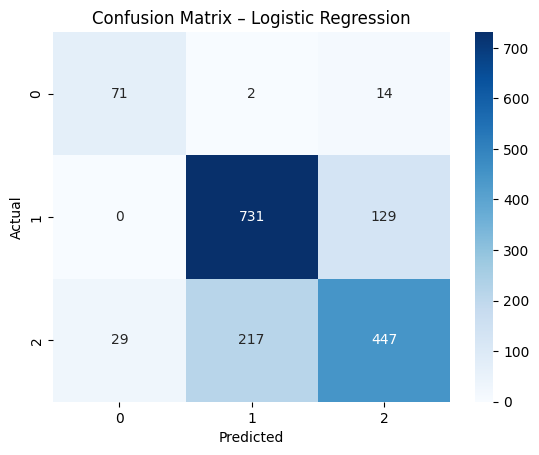

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_gp, y_pred_gp)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Logistic Regression')
plt.show()


In [16]:
# another way to evaluate how well
#your Logistic Regression model is performing
#ROC AUC is a performance metric
from sklearn.metrics import roc_auc_score

# Get probabilities for ALL classes
y_prob_gp = log_model.predict_proba(X_test_gp)

# Multiclass ROC-AUC using One-vs-Rest
roc_auc = roc_auc_score(
    y_test_gp,
    y_prob_gp,
    multi_class='ovr',
    average='macro'
)

roc_auc


np.float64(0.8891620408576285)

In [17]:
# This block of code is designed to help us
#understand which features are most influential

feature_names = (
    log_model.named_steps['preprocess']
    .get_feature_names_out()
)

coefficients = log_model.named_steps['clf'].coef_[0]

# Data frame basically means creating a table
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

coef_df.head(10)


,Feature,Coefficient
1,num__Reviews,12.447991
35,cat__Category_VIDEO_PLAYERS,1.265820
29,cat__Category_PRODUCTIVITY,1.240112
33,cat__Category_TOOLS,1.050161
4,cat__Category_ART_AND_DESIGN,1.002735
13,cat__Category_ENTERTAINMENT,0.981541
28,cat__Category_PHOTOGRAPHY,0.890293
34,cat__Category_TRAVEL_AND_LOCAL,0.826302
8,cat__Category_BUSINESS,0.768236
43,cat__Type_Free,0.728193


In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(

        #model will build 200 individual decision trees
        n_estimators=200,

        #If you run the code again,
        #you'll get the exact same random splits and results,
        random_state=42,
        class_weight='balanced'
    ))
])

#model training
rf_model.fit(X_train_gp, y_train_gp)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Rating', 'Reviews', 'Size',
                                                   'Price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Content Rating',
                                                   'Type'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [19]:
#finding influential features by RandomForest model
#unlike logistic regression which has coeff this one has importance

importances = rf_model.named_steps['clf'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)


,Feature,Importance
1,num__Reviews,0.662093
2,num__Size,0.114019
0,num__Rating,0.081358
18,cat__Category_GAME,0.011718
43,cat__Type_Free,0.011696
3,num__Price,0.010006
44,cat__Type_Paid,0.009136
15,cat__Category_FAMILY,0.007931
33,cat__Category_TOOLS,0.007672
38,cat__Content Rating_Everyone,0.005914


=== RANDOM FOREST PERFORMANCE ===
Accuracy: 0.9207317073170732
              precision    recall  f1-score   support

        High       0.84      0.64      0.73        87
         Low       0.94      0.96      0.95       860
      Medium       0.91      0.91      0.91       693

    accuracy                           0.92      1640
   macro avg       0.89      0.84      0.86      1640
weighted avg       0.92      0.92      0.92      1640



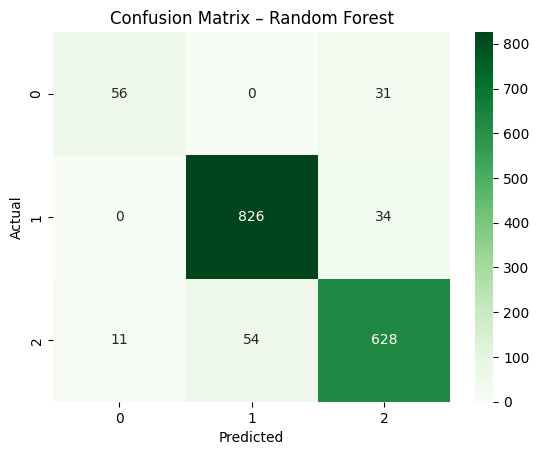

Random Forest ROC-AUC: 0.9765
Random Forest Mean CV F1-score: 0.8594


In [20]:
# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test_gp)

print("=== RANDOM FOREST PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test_gp, y_pred_rf))
print(classification_report(y_test_gp, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test_gp, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Random Forest')
plt.show()

# ROC-AUC for Random Forest
y_prob_rf = rf_model.predict_proba(X_test_gp)
roc_auc_rf = roc_auc_score(y_test_gp, y_prob_rf, multi_class='ovr', average='macro')
print(f"Random Forest ROC-AUC: {roc_auc_rf:.4f}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_gp, y_gp, cv=5, scoring='f1_macro')
print(f"Random Forest Mean CV F1-score: {cv_scores_rf.mean():.4f}")

In [21]:
# Model Comparison Summary
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Test Accuracy': [
        accuracy_score(y_test_gp, y_pred_gp),
        accuracy_score(y_test_gp, y_pred_rf)
    ],
    'ROC-AUC': [roc_auc, roc_auc_rf],
    'CV F1-Score': [cv_scores.mean(), cv_scores_rf.mean()]
})

print("\n=== MODEL COMPARISON ===")
print(comparison)


=== MODEL COMPARISON ===
                 Model  Test Accuracy   ROC-AUC  CV F1-Score
0  Logistic Regression       0.761585  0.889162     0.678662
1        Random Forest       0.920732  0.976507     0.859402


Model Selection Justification:
- Tested two algorithms: Logistic Regression (baseline) and Random Forest
- Random Forest significantly outperformed on all metrics
- The 16% accuracy improvement and 0.087 ROC-AUC gain justify the
  additional computational complexity
- Cross-validation confirms Random Forest generalizes better (F1: 0.86 vs 0.68)

Model Training for App Store

In [22]:
from sklearn.model_selection import train_test_split

X_train_as, X_test_as, y_train_as, y_test_as = train_test_split(
    X_as,
    y_as,
    test_size=0.2,
    random_state=42,
    stratify=y_as
)


In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_features_as = [
    'price',
    'size_mb',
    'user_rating',
    'rating_count_ver',
    'lang.num'
]

cat_features_as = [
    'prime_genre',
    'cont_rating'
]

preprocessor_as = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_as),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_as)
    ]
)


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_model_as = Pipeline([
    ('preprocess', preprocessor_as),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model_as.fit(X_train_as, y_train_as)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price', 'size_mb',
                                                   'user_rating',
                                                   'rating_count_ver',
                                                   'lang.num']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['prime_genre',
                                                   'cont_rating'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [25]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_as = rf_model_as.predict(X_test_as)

print("=== APP STORE RANDOM FOREST PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test_as, y_pred_as))
print(classification_report(y_test_as, y_pred_as))


=== APP STORE RANDOM FOREST PERFORMANCE ===
Accuracy: 0.6831132731063239
              precision    recall  f1-score   support

        High       0.73      0.72      0.72       480
         Low       0.76      0.77      0.77       481
      Medium       0.56      0.56      0.56       478

    accuracy                           0.68      1439
   macro avg       0.68      0.68      0.68      1439
weighted avg       0.68      0.68      0.68      1439



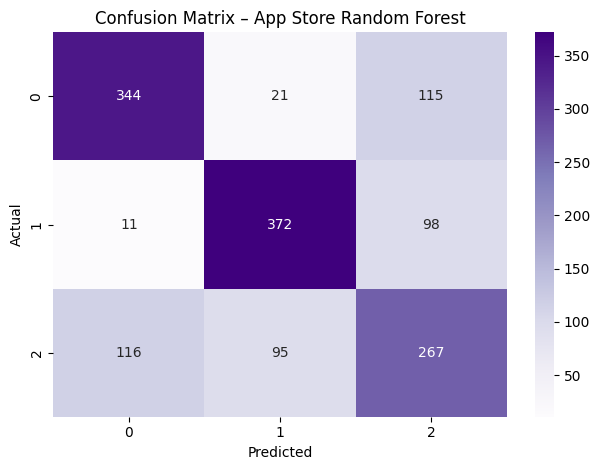

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_as = confusion_matrix(y_test_as, y_pred_as)

sns.heatmap(cm_as, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – App Store Random Forest')
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import roc_auc_score

y_prob_as = rf_model_as.predict_proba(X_test_as)

roc_auc_as = roc_auc_score(
    y_test_as,
    y_prob_as,
    multi_class='ovr',
    average='macro'
)

print(f"App Store ROC-AUC: {roc_auc_as:.4f}")


App Store ROC-AUC: 0.8690


In [28]:
feature_names_as = (
    rf_model_as.named_steps['preprocess']
    .get_feature_names_out()
)

importances_as = rf_model_as.named_steps['clf'].feature_importances_

importance_df_as = pd.DataFrame({
    'Feature': feature_names_as,
    'Importance': importances_as
}).sort_values(by='Importance', ascending=False)

importance_df_as.head(10)


,Feature,Importance
3,num__rating_count_ver,0.360442
1,num__size_mb,0.193609
2,num__user_rating,0.156204
4,num__lang.num,0.095778
0,num__price,0.065922
12,cat__prime_genre_Games,0.016199
30,cat__cont_rating_4+,0.011829
28,cat__cont_rating_12+,0.008675
9,cat__prime_genre_Entertainment,0.008188
31,cat__cont_rating_9+,0.007964
